In [1]:
import os
import glob
from torch.utils.data import DataLoader
from custom_dataset_cross import MyDataset
import cv2
from share import *
import torchvision
import einops
import numpy as np
from ldm.modules.encoders.modules import FrozenClipImageEmbedder
import torch.nn.functional as F
import config
import gradio as gr
import random
import torch
from PIL import Image
from annotator.util import resize_image, HWC3
from cldm.model import create_model, load_state_dict
from ldm.models.diffusion.ddim import DDIMSampler
from pytorch_lightning import seed_everything

os.environ["CUDA_VISIBLE_DEVICES"]="4"

dataset = MyDataset("kin_hed_val")

def get_key(name: str):
    name = name.split(".")[1]
    name = name.split("_")[-1]
    name = name[3:]
    return int(name)


def get_sequence(dl):
    for batch in dl:
        batch_meta = batch["meta"]["file_name"]
        meta = batch_meta[0]
        meta = meta.split("/")[1]
        meta = meta.split("_")[:-1]
        meta = "_".join(meta)
        print(meta)
        styles = glob.glob("./data/kin_hed_val/jpg/" + meta + "*")
        styles.sort(key=get_key)
        structures = glob.glob("./data/kin_hed_val/hint/" + meta + "*")
        structures.sort(key=get_key)
        print(styles)
        print(structures)
        return styles, structures


def get_img(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = img.astype(np.float32) / 255.0
    return img

logging improved.


/export/home/nstracke/miniconda3/envs/control/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/export/home/nstracke/miniconda3/envs/control/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):


In [2]:
p = "./train_log/kin_hed_dropout1/lightning_logs/version_1/checkpoints/epoch=6-step=595385.ckpt"
# p = "./models/inter1.ckpt"
# p = "./train_log/kin_hed_2/lightning_logs/version_0/checkpoints/epoch=1-step=119930.ckpt"
# p = './train_log/kin_hed_cross_3/lightning_logs/version_0/checkpoints/epoch=4-step=412223.ckpt'

model = create_model("./models/cldm_v15_cross.yaml").cuda()
model.load_state_dict(load_state_dict(p, location="cuda"))
ddim_sampler = DDIMSampler(model)
frozenClipImageEmbedder = model.style_encoder


/export/home/nstracke/miniconda3/envs/control/lib/python3.8/site-packages/torch/distributed/_sharded_tensor/__init__.py:8: DeprecationWarning: torch.distributed._sharded_tensor will be deprecated, use torch.distributed._shard.sharded_tensor instead
  warnings.warn(


ControlLDM: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_

In [3]:
from einops import rearrange
from torchvision.models.optical_flow import raft_large
from torchvision.models.optical_flow import Raft_Large_Weights


def disabled_train(self, mode=True):
    """Overwrite model.train with this function to make sure train/eval mode
    does not change anymore."""
    return self
    

def warp_frame(start_frame, flow, round=True):
    warped_frame = torch.ones_like(start_frame) * -1.0
    target_mask = torch.ones_like(start_frame)[:, 0] * -1.0
    target_mask = rearrange(target_mask, "b h w -> b 1 h w")
    flowlength = torch.sqrt(torch.sum(flow**2, dim=1))  # length of the flow vector
    flowlength = rearrange(flowlength, "n h w -> n (h w)")
    source_indices = torch.argsort(
        flowlength, dim=-1
    )  # sort by  warping pixels with small flow first
    xx, yy = torch.meshgrid(
        torch.arange(start_frame.size(2)),
        torch.arange(start_frame.size(3)),
        indexing="xy",
    )
    grid = (
        torch.cat([xx.unsqueeze(0), yy.unsqueeze(0)], dim=0)
        .unsqueeze(0)
        .repeat(start_frame.size(0), 1, 1, 1)
        .cuda()
    )

    if round:
        vgrid = grid + torch.round(flow).long()
    else:
        vgrid = grid + flow.long()

    maskw = torch.logical_and(
        vgrid[:, 0, :, :] >= 0, vgrid[:, 0, :, :] < start_frame.size(3)
    )
    maskh = torch.logical_and(
        vgrid[:, 1, :, :] >= 0, vgrid[:, 1, :, :] < start_frame.size(2)
    )
    mask = torch.logical_and(
        maskw, maskh
    )  # mask of pixels we are allowed to move to prevent out of domain mapping
    mask = rearrange(mask, "n h w -> n (h w)")

    for b in range(start_frame.size(0)):
        # filter indices
        filtered_source_indices = torch.masked_select(
            source_indices[b], mask[b, source_indices[b]]
        )  # only select source indices which don't map out of domain
        source_pixels = torch.index_select(
            rearrange(start_frame[b], "c h w -> c (h w)"), -1, filtered_source_indices
        )  # order pixels from source image
        target_indices = torch.index_select(
            rearrange(vgrid[b], "c h w -> c (h w)"), -1, filtered_source_indices
        )
        target_indices = (
            target_indices[1] * start_frame.size(3) + target_indices[0]
        )  # convert to flattened indices

        # create mask here for inpainting
        temp_mask = torch.ones((start_frame.size(2) * start_frame.size(3))).cuda() * 1.0
        temp_mask[
            target_indices
        ] = -1.0  # black pixels are kept, only white pixels should be masked regions
        target_mask[b] = rearrange(temp_mask, "(h w) -> 1 h w", h=start_frame.size(2))

        # set pixel at target_indices location
        temp = (
            torch.ones(
                (start_frame.size(1), start_frame.size(2) * start_frame.size(3))
            ).cuda()
            * -1.0
        )
        temp[:, target_indices] = source_pixels
        warped_frame[b] = rearrange(temp, "c (h w) -> c h w", h=start_frame.size(2))

    return warped_frame, target_mask  # warped_frame is (n c h w)

def show(w):
    w = rearrange(w, 'b c h w -> h (b w) c')
    w = w.cpu().numpy()
    w = (w+1) * 127.5
    w = w.clip(0,255).astype(np.uint8)

    return Image.fromarray(w)


flownet = raft_large(weights=Raft_Large_Weights.DEFAULT, progress=False).to('cuda')
flownet = flownet.eval()
flownet.train = disabled_train

In [7]:
def repeat(batch_img, repeat):
    return einops.repeat(batch_img, "b ... -> (repeat b) ...", repeat=repeat)


ddim_steps = 40
strength = 1
eta = 0
scale = 7
rr = 1
use_warp = True


torch.manual_seed(42)
dl = DataLoader(dataset, shuffle=True)

for i in range(10):
    grid = []
    while len(grid) < 5:
        styles, structures = get_sequence(dl)
        styles = np.array([get_img(style) for style in styles])
        styles = styles.copy().astype(np.uint8)

        if use_warp:
            styles = styles[1:]

        structures = np.array([get_img(structure) for structure in structures])
        structures = structures.astype(np.float32) / 255.0

        B, H, W, C = structures.shape

        if B < 4:
            continue

        control = torch.from_numpy(structures.copy()).float().cuda()
        control = einops.rearrange(control, "b h w c -> b c h w")

        if use_warp:
            control = control * 2. - 1.
            b1 = control[0:-1]
            b2 = control[1:]
            flow = flownet(b1, b2)[-1] # get last flow
            warped_control, _ = warp_frame(b1, flow)
            # make sure HED is only black/white
            # maybe max would be better - not sure
            control = einops.repeat(warped_control.mean(1, keepdim=True), 'b c ... -> b (r c) ...', r=3)
            control = (control + 1.) / 2.

            # we lose one structure smaple here
            B = B-1
      
        styles_first = np.repeat(styles[[0]], B, axis=0)


        style_embedding = frozenClipImageEmbedder(styles_first)

        c_style = style_embedding.last_hidden_state
        c_embed = style_embedding.pooler_output
        c_prompt = model.get_learned_conditioning(
            ["a professional, detailed, high-quality image"] * B
        )

        uc_style = torch.zeros_like(c_style)
        uc_embed = torch.zeros_like(c_embed)
        uc_prompt = model.get_learned_conditioning([""] * B)

        cond = {
            "c_concat": [repeat(control, rr)],
            "c_crossattn": [repeat(c_prompt, rr)],
            "c_style": [torch.cat([c_style], axis=0)],
            "c_embed": [torch.cat([c_embed], axis=0)],
        }
        un_cond = {
            "c_concat": [repeat(control, rr)],
            "c_crossattn": [repeat(uc_prompt, rr)],
            "c_style": [repeat(uc_style, rr)],
            "c_embed": [repeat(uc_embed, rr)],
        }
        shape = (4, H // 8, W // 8)

        model.control_scales = [
            strength
        ] * 13  # Magic number. IDK why. Perhaps because 0.825**12<0.01 but 0.826**12>0.01

        samples, intermediates = ddim_sampler.sample(
            ddim_steps,
            B * rr,
            shape,
            cond,
            verbose=False,
            eta=eta,
            unconditional_guidance_scale=scale,
            unconditional_conditioning=un_cond,
        )

        d_samples = model.decode_first_stage(samples)
        x_samples = (
            einops.rearrange(d_samples, "(r b) c h w -> (r h) (b w) c", r=rr) * 127.5 + 127.5
        )
        x_samples = x_samples.cpu().numpy().clip(0, 255).astype(np.uint8)
        x_samples = np.concatenate(
            [np.zeros((512 * rr, 512, 3), dtype=np.uint8), x_samples], axis=1
        )

        f_styles = (
            einops.rearrange(styles, "b h w c -> h (b w) c").clip(0, 255).astype(np.uint8)
        )

        final = np.concatenate([f_styles, x_samples], axis=0)

        grid.append(final)

    f_grid = np.concatenate(grid, axis=0)
    Image.fromarray(f_grid).save(f"flow_samples/grid_{i}.png")

4YGHeNdGPkA_000019_000029
['./data/kin_hed_val/jpg/4YGHeNdGPkA_000019_000029_idx0.png', './data/kin_hed_val/jpg/4YGHeNdGPkA_000019_000029_idx500.png', './data/kin_hed_val/jpg/4YGHeNdGPkA_000019_000029_idx1000.png', './data/kin_hed_val/jpg/4YGHeNdGPkA_000019_000029_idx1500.png', './data/kin_hed_val/jpg/4YGHeNdGPkA_000019_000029_idx2000.png']
['./data/kin_hed_val/hint/4YGHeNdGPkA_000019_000029_idx500.png', './data/kin_hed_val/hint/4YGHeNdGPkA_000019_000029_idx1000.png', './data/kin_hed_val/hint/4YGHeNdGPkA_000019_000029_idx1500.png', './data/kin_hed_val/hint/4YGHeNdGPkA_000019_000029_idx2000.png']
Data shape for DDIM sampling is (3, 4, 64, 64), eta 0
Running DDIM Sampling with 40 timesteps


DDIM Sampler:  42%|████▎     | 17/40 [00:05<00:07,  3.24it/s]

In [ ]:
styles, structures = get_sequence(dl)

PrSvxo90liQ_000196_000206
['./data/kin_hed_val/jpg/PrSvxo90liQ_000196_000206_idx0.png', './data/kin_hed_val/jpg/PrSvxo90liQ_000196_000206_idx500.png', './data/kin_hed_val/jpg/PrSvxo90liQ_000196_000206_idx1000.png', './data/kin_hed_val/jpg/PrSvxo90liQ_000196_000206_idx1500.png', './data/kin_hed_val/jpg/PrSvxo90liQ_000196_000206_idx2000.png']
['./data/kin_hed_val/hint/PrSvxo90liQ_000196_000206_idx500.png', './data/kin_hed_val/hint/PrSvxo90liQ_000196_000206_idx1000.png', './data/kin_hed_val/hint/PrSvxo90liQ_000196_000206_idx1500.png', './data/kin_hed_val/hint/PrSvxo90liQ_000196_000206_idx2000.png']


In [ ]:
styles = np.array([get_img(style) for style in styles])
styles = einops.rearrange(styles, 'b h w c -> b c h w')
styles = styles / 127.5 -1
styles = torch.from_numpy(styles)

b1 = styles[0:-1].float().cuda()
b2 = styles[1:].float().cuda()

In [ ]:
structures = np.array([get_img(s) for s in structures])
structures = einops.rearrange(structures, 'b h w c -> b c h w')
structures = structures / 127.5 -1
structures = torch.from_numpy(structures)

b1 = structures[0:-1].float().cuda()
b2 = structures[1:].float().cuda()

In [ ]:
flow = model(b1, b2)[-1]

In [ ]:
warped_frames, _ = warp_frame(b1, flow)
# warped_frames[warped_frames <= 0] = -1
# warped_frames[warped_frames > 0] = 1

In [ ]:
test, _ = warped_frames.max(1,keepdim=True)
test = einops.repeat(test, 'b c ... -> b (r c) ...', r=3)

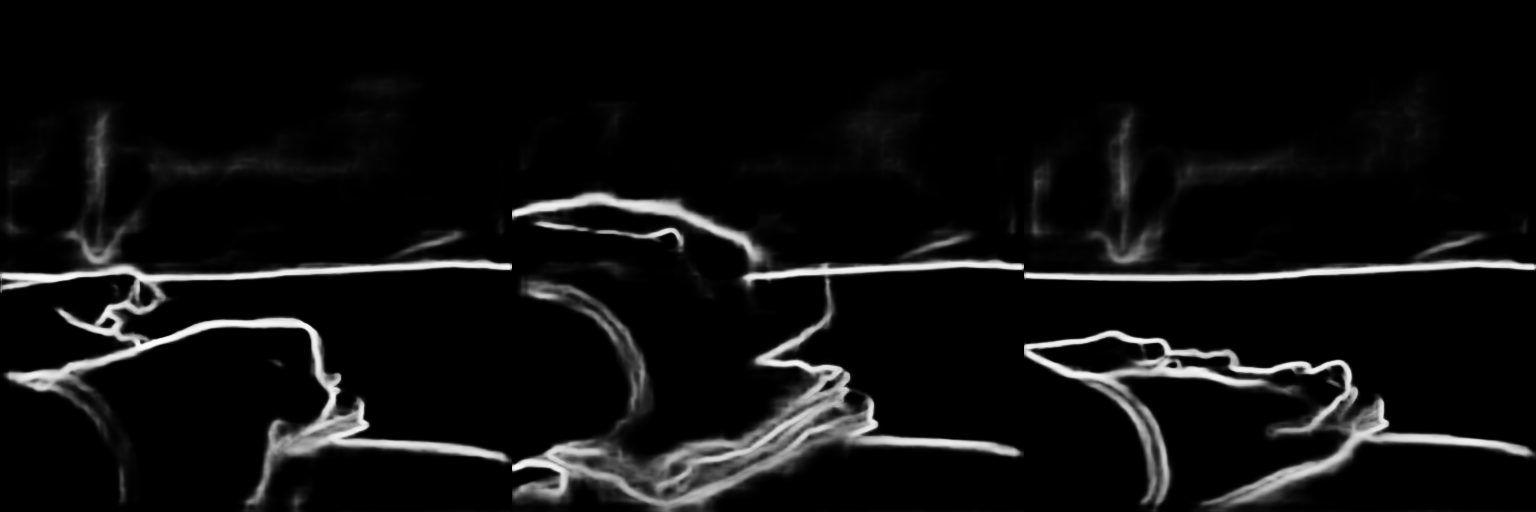

In [ ]:
show(b1)

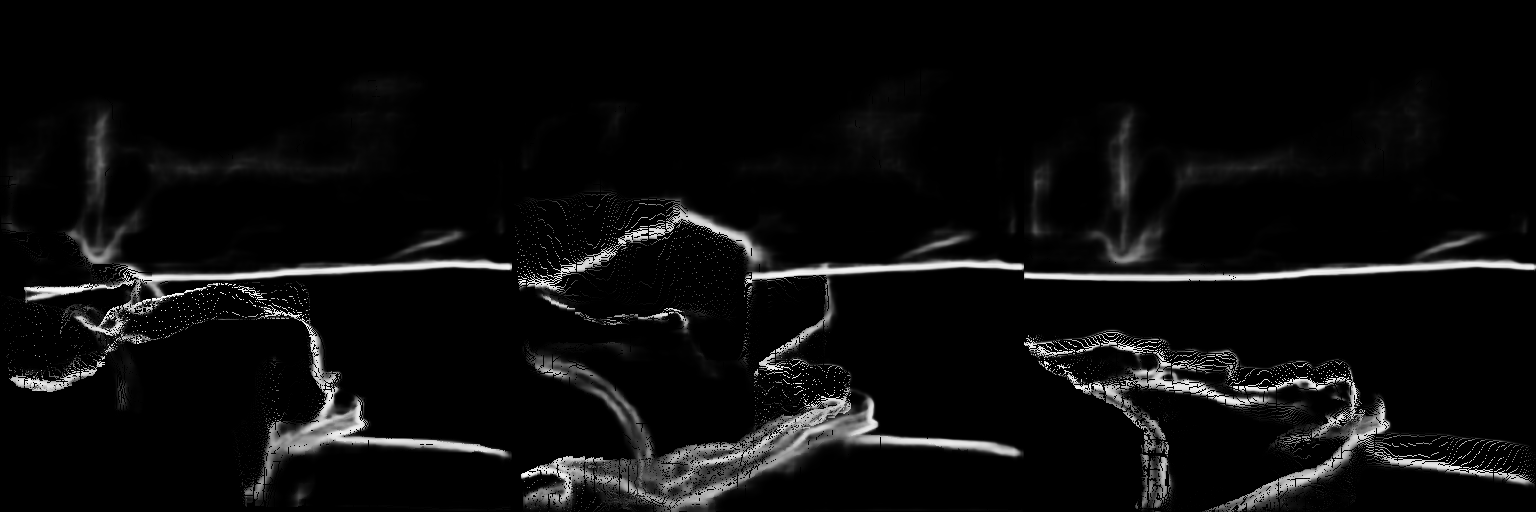

In [ ]:
show(test)

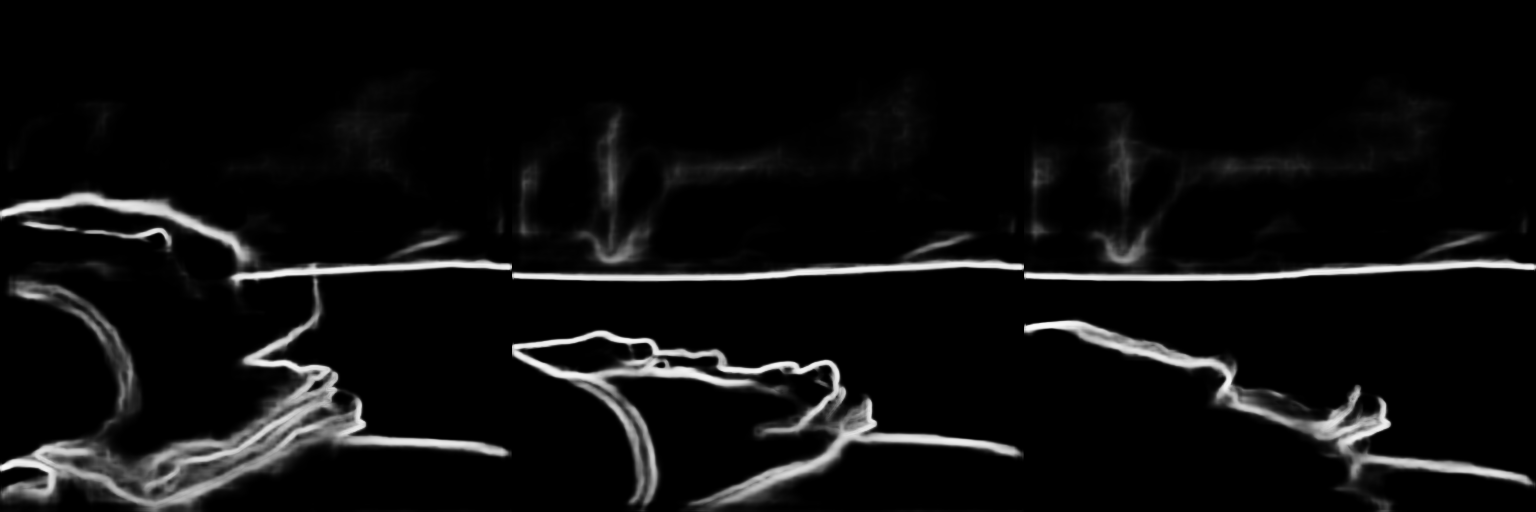

In [ ]:
show(b2)